# 2 layer synthetic inversion

Here we try to recover the true Layer 2 topography with a gravity inversion. The gravity data is the forward gravity of Layer 1 and 2, representing a perfect gravity survey with no error. The inputs into the inversion are a full resolution Layer 1, representing the `ice surface`, and a low resolution Layer 2, representing the `bed topography`, which has been created through the random sampling and grid of 30 contraint points. In an Antarctic setting, these points represent single seismic survey locations which image the elevation of Layer 2. 

import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth 
import RIS_gravity_inversion.optimization as opti 

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings 
import os

# Set region and parameters

Use the same regions and parameters as `synthetic_model_simple_2layer.ipynb`

In [3]:
# set grid parameters
spacing = 1e3
registration = "g"
inversion_region = [0, 80e3, 0, 60e3]

# set gravity observation parameters
grav_observation_height = 1000
grav_spacing = 1e3  # true spacing was 2km for sampled, 1km for full res

buffer_region = utils.alter_region(
    inversion_region,
    # buffer=12e3,
)[1]


print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [0, 80000.0, 0, 60000.0]
buffer region =  [0, 80000, 0, 60000]


# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [1]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

true_layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

starting_layer2 = xr.open_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr"
)["z"]

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
true_layer2 = true_layer2.astype(np.float64)
starting_layer2 = starting_layer2.astype(np.float64)

# resample all layer to same spacing / extent
layer1 = fetch.resample_grid(
    layer1,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
true_layer2 = fetch.resample_grid(
    true_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
starting_layer2 = fetch.resample_grid(
    starting_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)

print(utils.get_grid_info(starting_layer2))
starting_layer2

NameError: name 'xr' is not defined

## gravity data
* full resolution gravity grid
* gravity observations

In [5]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple_2layer.zarr")

# use full grid
grav = vd.grid_to_table(synthetic_gravity.astype(np.float64))

# set standard column names
grav = grav.rename(columns={'forward_total':'Gobs'})

# remove other columns
grav = grav[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav.Gobs -= grav.Gobs.median()

print(f"gravity: {len(grav)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav.z))}")

# grid the observed gravity
Gobs = grav.set_index(["y", "x"]).to_xarray().Gobs

grav

gravity: 4941 points
gravity avg. elevation: 1000


x        y       Gobs       z
0         0.0      0.0  10.581479  1000.0
1      1000.0      0.0  12.551074  1000.0
2      2000.0      0.0  13.172549  1000.0
3      3000.0      0.0  13.253567  1000.0
4      4000.0      0.0  13.104524  1000.0
...       ...      ...        ...     ...
4936  76000.0  60000.0   3.023554  1000.0
4937  77000.0  60000.0   3.088488  1000.0
4938  78000.0  60000.0   3.132262  1000.0
4939  79000.0  60000.0   3.120086  1000.0
4940  80000.0  60000.0   2.984933  1000.0

[4941 rows x 4 columns]

## constraint points

In [2]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all,
    inversion_region,
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

NameError: name 'pd' is not defined

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast across Layer 1 (air-ice) and Layer 2 (ice-bed). Since we want to invert for Layer 2, we need to remove the component of this gravity from Layer 1. To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of Layer 1. The prisms extend above or below this reference, towards Layer 1. Prisms above the reference are assigned a positive density contrast ($\rho_{ice}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{ice}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bed elevation doesn't intersect Layer 1. This means the Layer 1 density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Ice prisms

In [7]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    top=layer1,
    bottom=layer1.values.mean(),
    density=xr.where(layer1 >= layer1.values.mean(), 917, -917),
)

# plots.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## ice gravity

In [8]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav,
    names=['layer1_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

grav['layer1_forward'] = layer1_df.forward_total

# subtract from observed gravity
grav['Gobs_corr']=grav.Gobs - grav.layer1_forward

# center on 0
grav['Gobs_corr'] -= grav['Gobs_corr'].median()

# grid the results
layer1_forward = grav.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= np.median(layer1_forward.values)
Gobs_corr -= np.median(Gobs_corr.values)
grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

x        y       Gobs       z  layer1_forward  Gobs_corr
0         0.0      0.0  10.581479  1000.0        7.079618   3.117193
1      1000.0      0.0  12.551074  1000.0        8.411450   3.754956
2      2000.0      0.0  13.172549  1000.0        8.769055   4.018826
3      3000.0      0.0  13.253567  1000.0        8.776992   4.091908
4      4000.0      0.0  13.104524  1000.0        8.645779   4.074078
...       ...      ...        ...     ...             ...        ...
4936  76000.0  60000.0   3.023554  1000.0        1.019056   1.619829
4937  77000.0  60000.0   3.088488  1000.0        1.105780   1.598040
4938  78000.0  60000.0   3.132262  1000.0        1.194986   1.552608
4939  79000.0  60000.0   3.120086  1000.0        1.282108   1.453309
4940  80000.0  60000.0   2.984933  1000.0        1.354322   1.245943

[4941 rows x 6 columns]

In [3]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title='Surface 1 forward gravity',
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

NameError: name 'maps' is not defined

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution Layer 2 density contrast. This will be the input into our inversion.


## Bed prisms

In [9]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    top=starting_layer2,
    bottom=starting_layer2.values.mean(),
    density=xr.where(starting_layer2>=starting_layer2.values.mean(), 2300-917, -(2300-917)),
)

# plots.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## bed gravity

In [10]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav,
    names=['layer2_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav['layer2_forward'] = layer2_df.forward_total
grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

x        y       Gobs       z  layer1_forward  Gobs_corr  \
0         0.0      0.0  10.581479  1000.0        7.079618   3.117193   
1      1000.0      0.0  12.551074  1000.0        8.411450   3.754956   
2      2000.0      0.0  13.172549  1000.0        8.769055   4.018826   
3      3000.0      0.0  13.253567  1000.0        8.776992   4.091908   
4      4000.0      0.0  13.104524  1000.0        8.645779   4.074078   
...       ...      ...        ...     ...             ...        ...   
4936  76000.0  60000.0   3.023554  1000.0        1.019056   1.619829   
4937  77000.0  60000.0   3.088488  1000.0        1.105780   1.598040   
4938  78000.0  60000.0   3.132262  1000.0        1.194986   1.552608   
4939  79000.0  60000.0   3.120086  1000.0        1.282108   1.453309   
4940  80000.0  60000.0   2.984933  1000.0        1.354322   1.245943   

      layer2_forward  
0           2.445618  
1           2.974444  
2           3.201610  
3           3.268290  
4           3.253918  
...              ...  
4936       -0.349516  
4937       -0.382226  
4938       -0.393327  
4939       -0.362025  
4940       -0.253643  

[4941 rows x 7 columns]

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


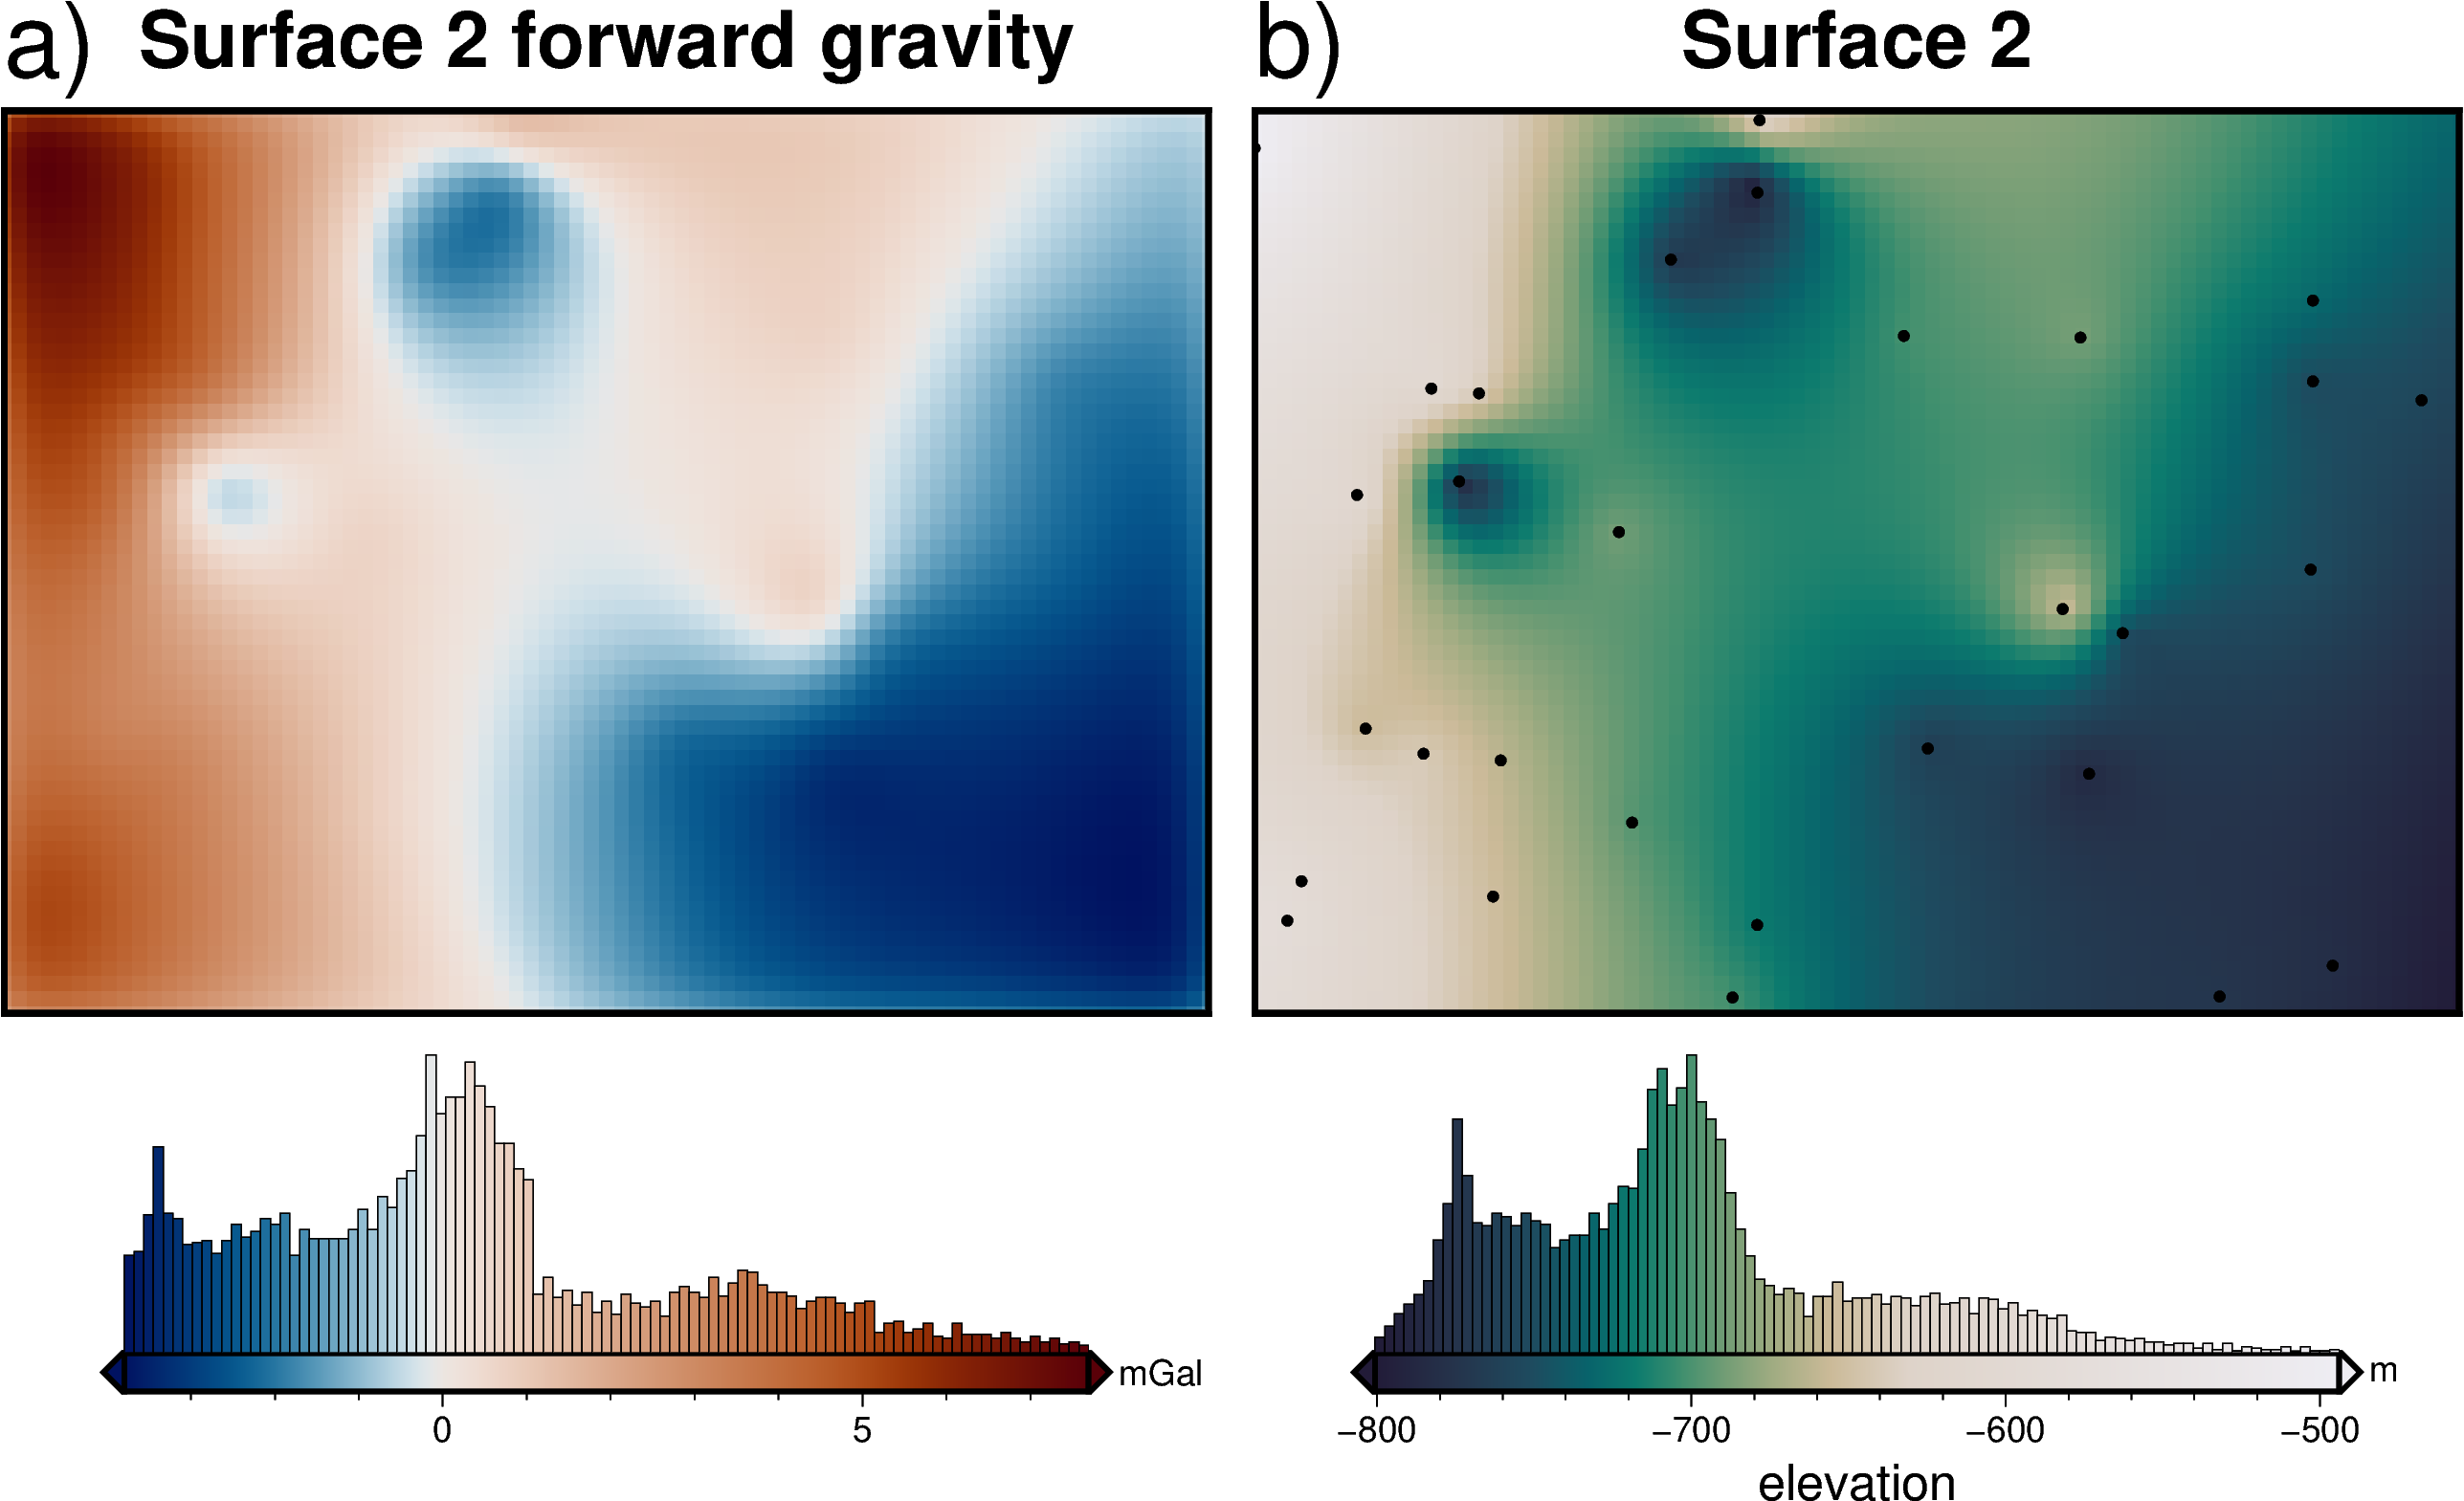

In [165]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

## calculate misfit

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


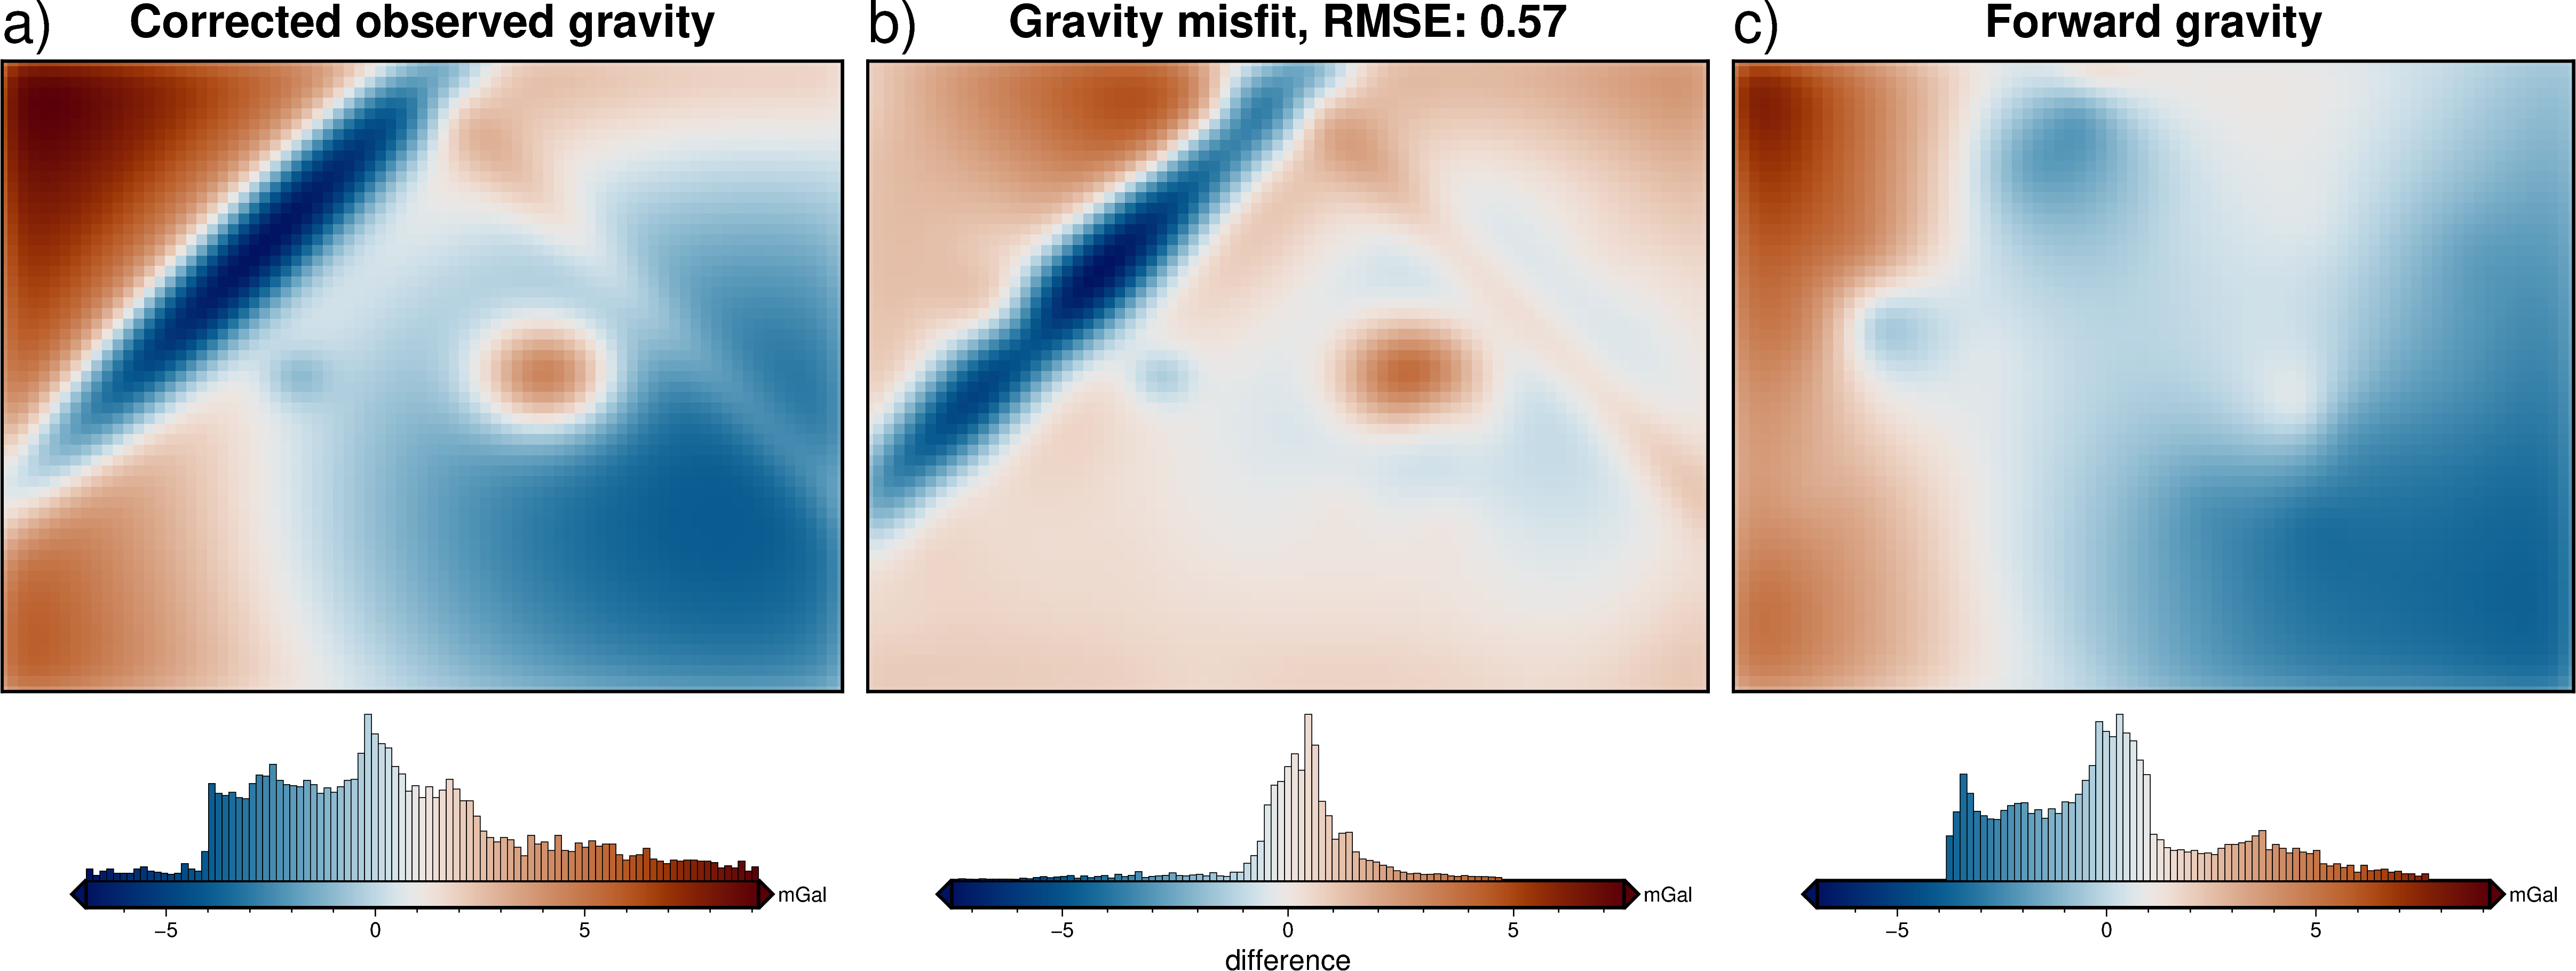

In [11]:
df_misfit = inv.misfit(
    input_grav = grav,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=grav_spacing,
    # plot=False,
    plot_type='pygmt',
)

In [12]:
df_misfit['reg']=0
df_misfit['res']=df_misfit.misfit
df_misfit

x        y       Gobs       z  layer1_forward  Gobs_corr  \
0         0.0      0.0  10.581479  1000.0        7.079618   3.117193   
1      1000.0      0.0  12.551074  1000.0        8.411450   3.754956   
2      2000.0      0.0  13.172549  1000.0        8.769055   4.018826   
3      3000.0      0.0  13.253567  1000.0        8.776992   4.091908   
4      4000.0      0.0  13.104524  1000.0        8.645779   4.074078   
...       ...      ...        ...     ...             ...        ...   
4936  76000.0  60000.0   3.023554  1000.0        1.019056   1.619829   
4937  77000.0  60000.0   3.088488  1000.0        1.105780   1.598040   
4938  78000.0  60000.0   3.132262  1000.0        1.194986   1.552608   
4939  79000.0  60000.0   3.120086  1000.0        1.282108   1.453309   
4940  80000.0  60000.0   2.984933  1000.0        1.354322   1.245943   

      layer2_forward    misfit  reg       res  
0           2.445618  0.671575    0  0.671575  
1           2.974444  0.780512    0  0.780512  
2           3.201610  0.817216    0  0.817216  
3           3.268290  0.823618    0  0.823618  
4           3.253918  0.820159    0  0.820159  
...              ...       ...  ...       ...  
4936       -0.349516  1.969345    0  1.969345  
4937       -0.382226  1.980266    0  1.980266  
4938       -0.393327  1.945936    0  1.945936  
4939       -0.362025  1.815335    0  1.815335  
4940       -0.253643  1.499586    0  1.499586  

[4941 rows x 10 columns]

# Plot inputs

In [168]:
# grid the residual misfit
residual = pygmt.surface(
        data=df_misfit[["x", "y", "res"]],
        region=inversion_region,
        spacing=grav_spacing,
        T=0.25,
        # M="0c",
        registration=registration,
    )

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


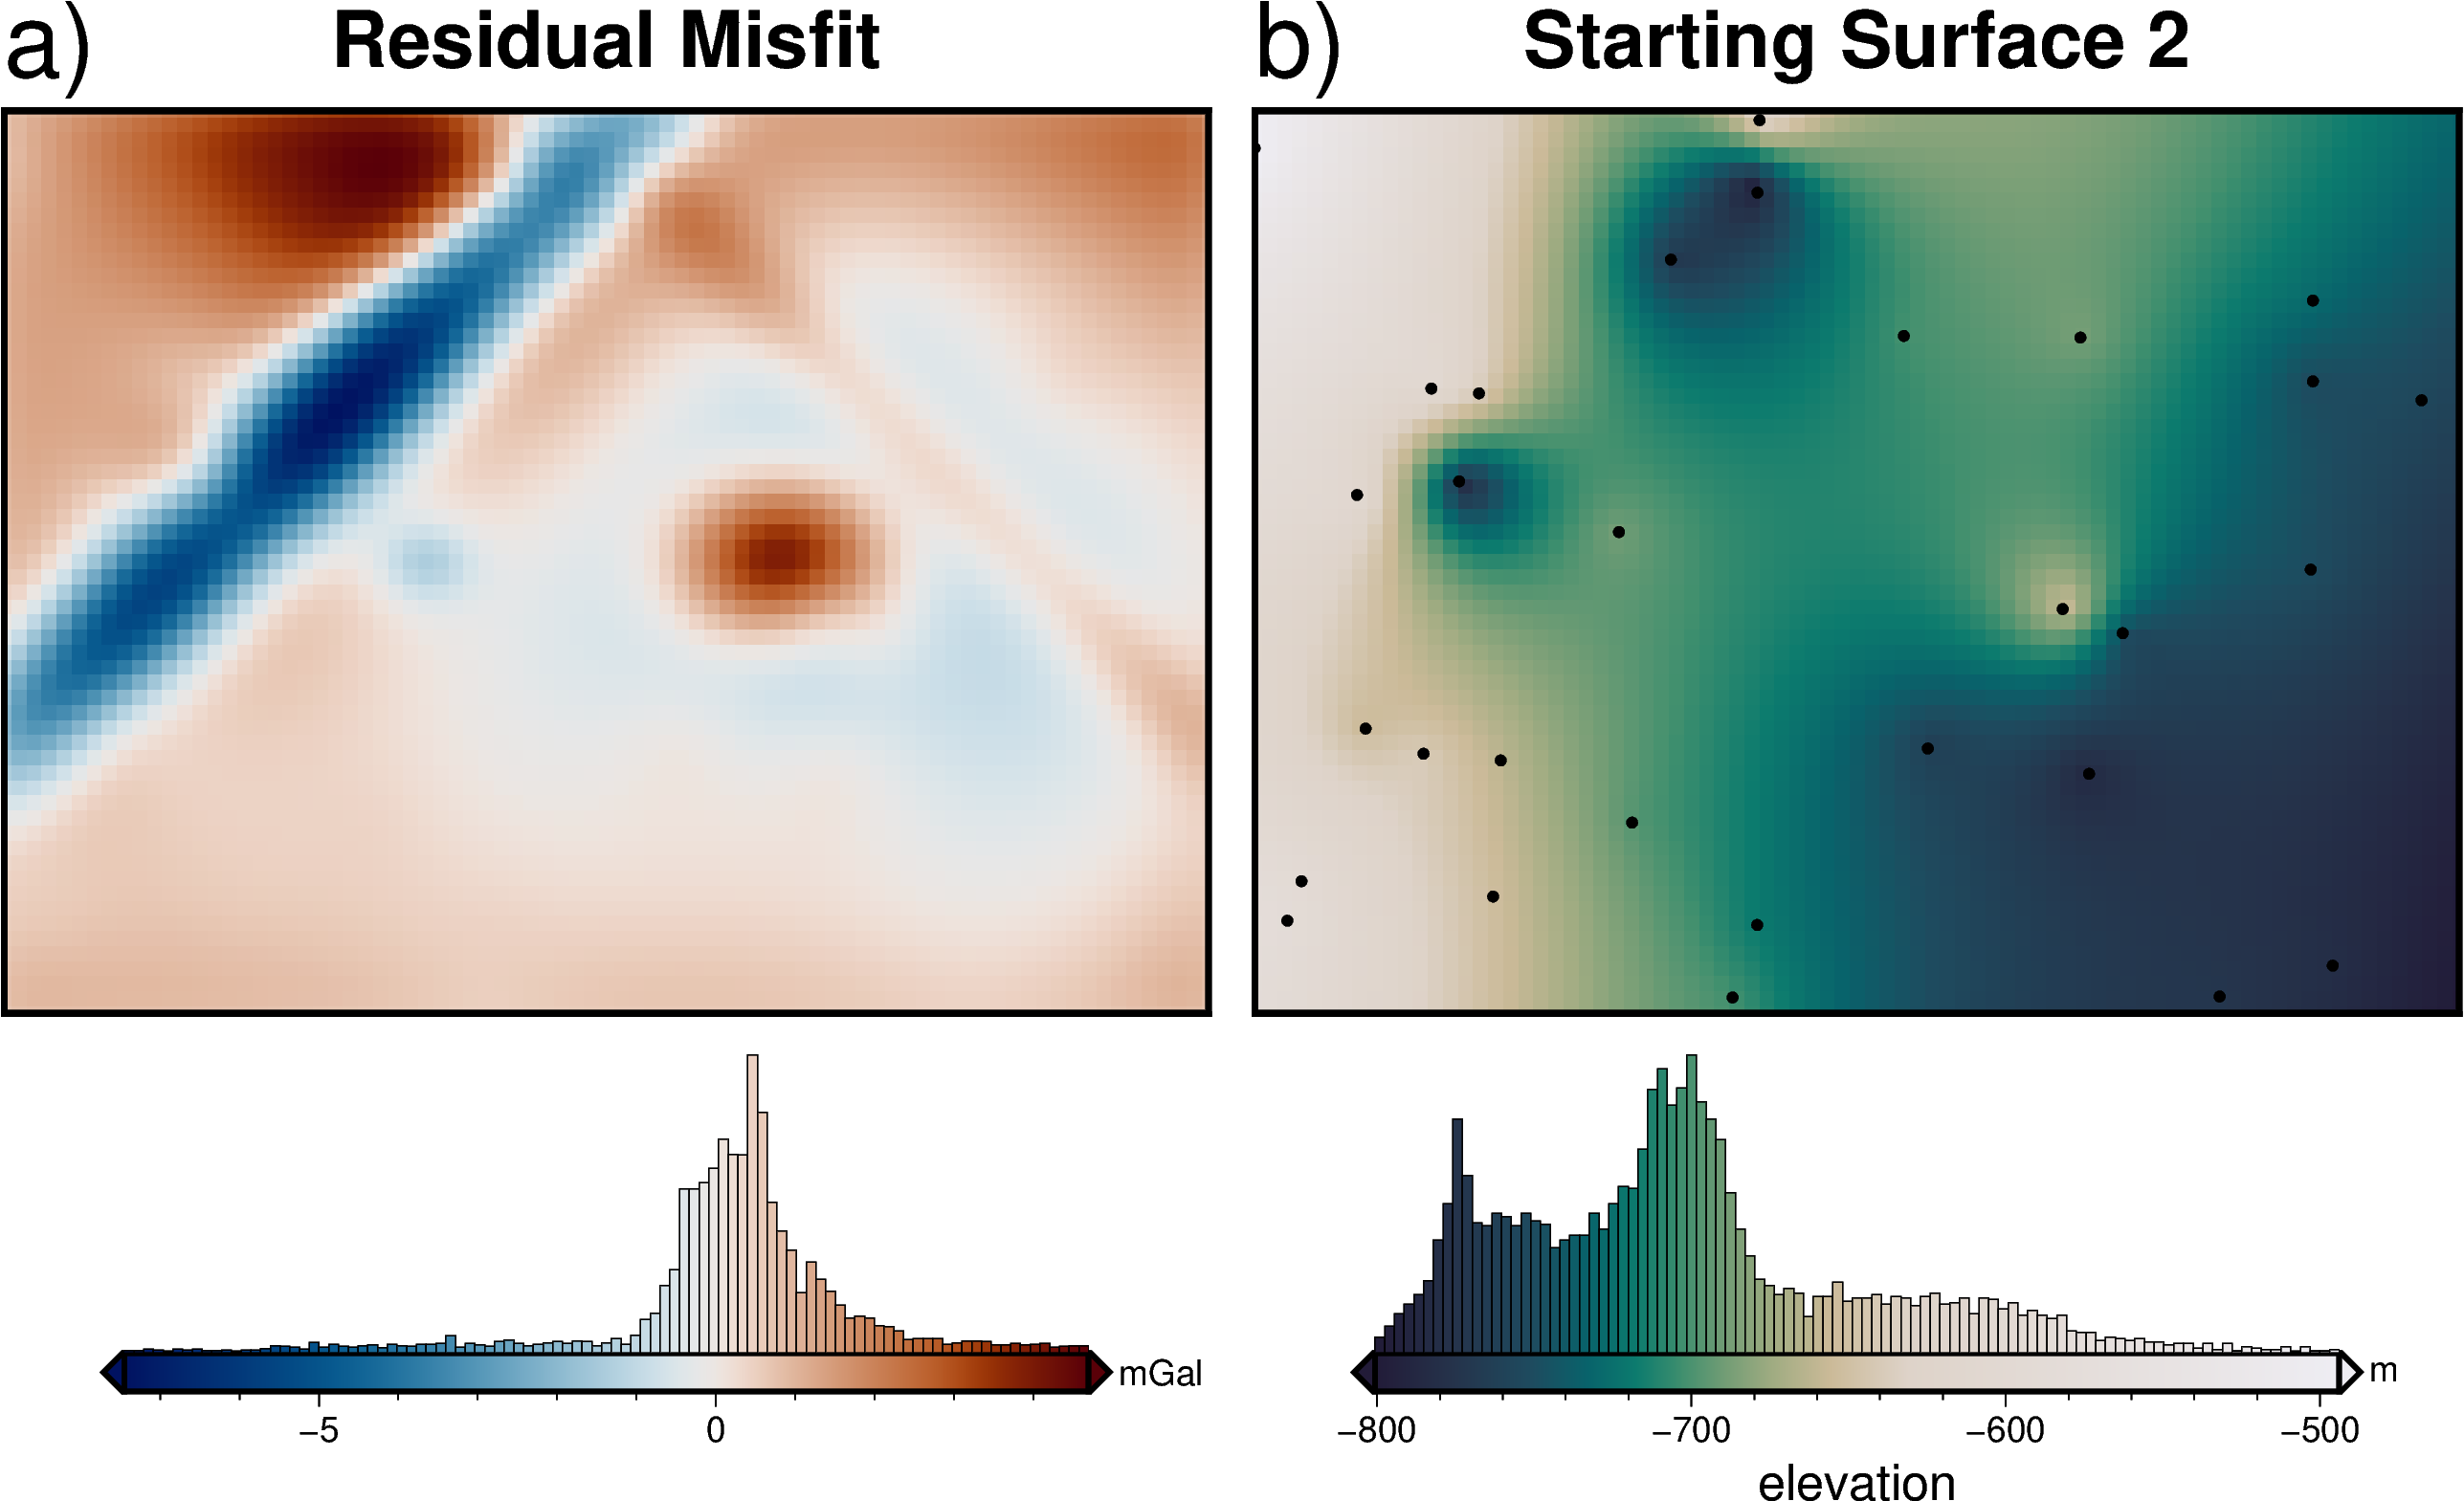

In [169]:
# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. Theres a number of parameters to choose from for the inversion.

In [81]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
kwargs = no_noise_kwargs

In [89]:
%%snakeviz 

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    input_grav = kwargs.get('input_grav'),
    input_grav_column = kwargs.get('input_grav_column'),
    prism_layer = kwargs.get('prism_layer'),
    max_iterations = kwargs.get('max_iterations'),
    l2_norm_tolerance = kwargs.get('l2_norm_tolerance'),
    delta_l2_norm_tolerance = kwargs.get('delta_l2_norm_tolerance'),
    max_layer_change_per_iter = best_params.get('max_layer_change_per_iter'),
    deriv_type = best_params.get('deriv_type'),
    solver_type = best_params.get('solver_type'),
    solver_damping = [v for k, v in best_params.items() if 'damping' in k.lower()][0],
        )


##############################################################################################
iteration 1
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.52
updated L2-norm: 0.72,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

##############################################################################################
iteration 2
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.49
updated L2-norm: 0.7,  tolerance: 0.2
updated delta L2-norm : 1.02,  tolerance: 0.8

##############################################################################################
iteration 3
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.47
updated L2-norm: 0.69,  tolerance: 0.2
updated delta L2-norm : 1.02,  tolerance: 0.8

##############################################################################################
iteration 4
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.45
updated L2-norm: 0.67,  tolerance: 0.2
updated del

In [90]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
kwargs = no_noise_kwargs

In [ ]:
%%snakeviz 

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    input_grav = kwargs.get('input_grav'),
    input_grav_column = kwargs.get('input_grav_column'),
    prism_layer = kwargs.get('prism_layer'),
    max_iterations = kwargs.get('max_iterations'),
    l2_norm_tolerance = kwargs.get('l2_norm_tolerance'),
    delta_l2_norm_tolerance = kwargs.get('delta_l2_norm_tolerance'),
    max_layer_change_per_iter = best_params.get('max_layer_change_per_iter'),
    deriv_type = best_params.get('deriv_type'),
    solver_type = best_params.get('solver_type'),
    solver_damping = [v for k, v in best_params.items() if 'damping' in k.lower()][0],
        )


##############################################################################################
iteration 1
Layer correction median: 0 m, RMSE:1 m

updated misfit RMSE: 0.49
updated L2-norm: 0.7,  tolerance: 0.2
updated delta L2-norm : 1.08,  tolerance: 0.8

##############################################################################################
iteration 2
Layer correction median: 0 m, RMSE:1 m

updated misfit RMSE: 0.43
updated L2-norm: 0.65,  tolerance: 0.2
updated delta L2-norm : 1.07,  tolerance: 0.8

##############################################################################################
iteration 3
Layer correction median: 0 m, RMSE:1 m

updated misfit RMSE: 0.38
updated L2-norm: 0.62,  tolerance: 0.2
updated delta L2-norm : 1.06,  tolerance: 0.8

##############################################################################################
iteration 4
Layer correction median: 0 m, RMSE:1 m

updated misfit RMSE: 0.35
updated L2-norm: 0.59,  tolerance: 0.2
updated del

In [ ]:
# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     input_grav=df_misfit,
#     input_grav_column = 'Gobs_corr',
#     prism_layer=layer2_prisms,
    
#     max_iterations=2,
#     l2_norm_tolerance=.2,
#     delta_l2_norm_tolerance=.8,

#     deriv_type = "annulus", 
#     # deriv_type = "prisms", 
#     # jacobian_prism_size = 1, # doesn't seem to make a difference

#     # solver_type = "verde least squares",
#     # solver_damping = 1e4,

#     solver_type = "scipy least squares",
#     solver_damping = .01,
# )

In [14]:
# grids = plots.plot_inversion_results(
#     grav_results,
#     prism_results, 
#     params,
#     grav_region=inversion_region,
#     grav_spacing=grav_spacing,
#     constraints=constraint_points,
#     plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=4,
#     )

# Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [13]:
# set kwargs for inversion
no_noise_kwargs = dict(
    input_grav = df_misfit,
    input_grav_column = 'Gobs_corr',
    prism_layer=layer2_prisms,
    max_iterations = 50,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = .8,
)

In [71]:
# set name and storage for the optimization
study_name = "2layer_inversion_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = opti.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **no_noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = opti.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

/tmp/ipykernel_3506921/3605175453.py:3: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



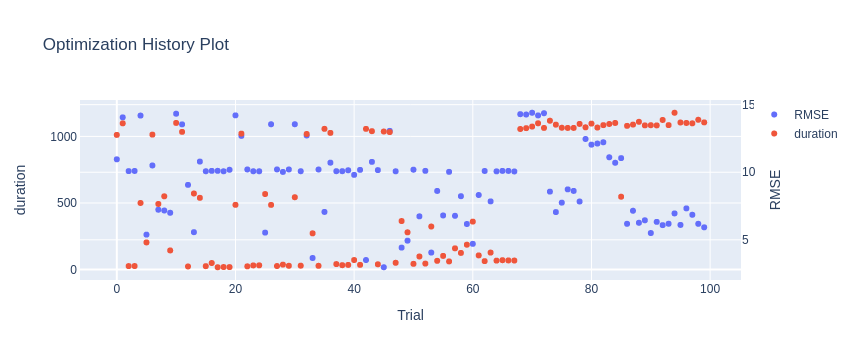

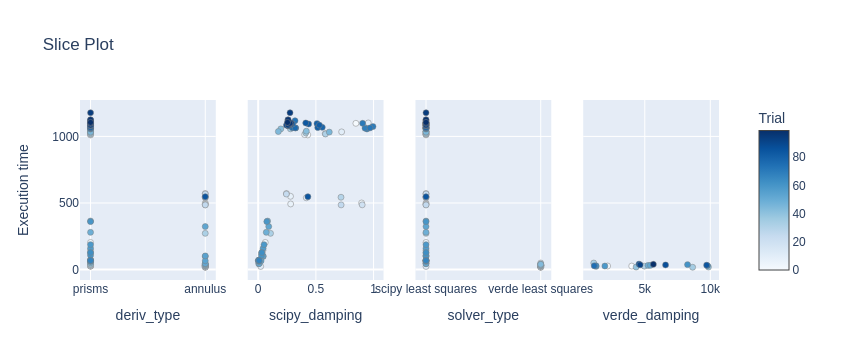

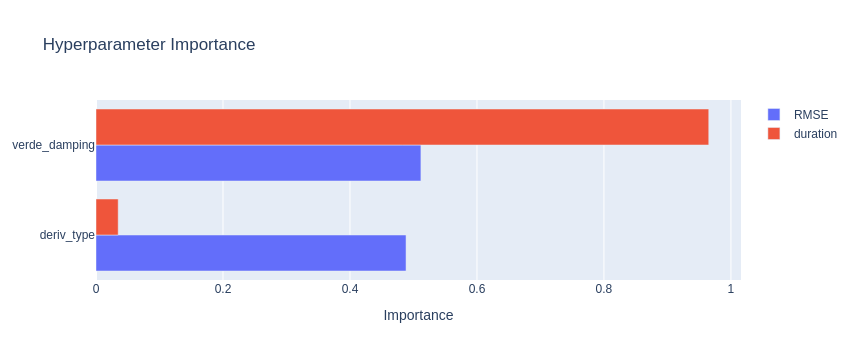

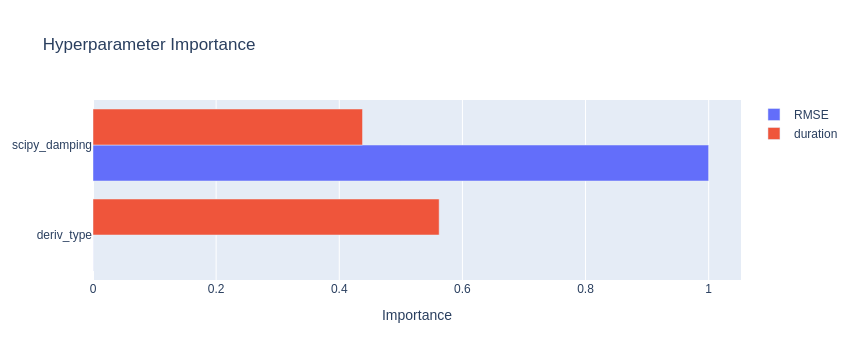

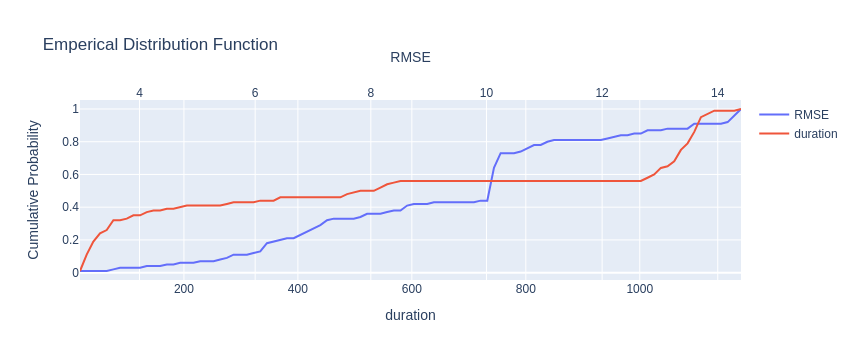

In [72]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    include_duration=True,
)

In [73]:
df_all = study.trials_dataframe()
start = df_all.sort_values(by="datetime_start").iloc[0].datetime_start
stop = df_all.sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

# df_all.sort_values(by="value")[0:20]

Total time for optimizaiton: 19.6628366 minutes


In [74]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

best trial w/ solver = verde: index 28
best trial w/ solver = scipy: index 45
best trial w/ deriv = prisms: index 45
best trial w/ deriv = annulus: index 33


number      value             datetime_start          datetime_complete  \
45      45   2.970534 2023-02-28 22:07:35.132779 2023-02-28 22:24:51.864590   
42      42   3.505643 2023-02-28 22:07:39.145447 2023-02-28 22:25:15.644867   
33      33   3.655072 2023-02-28 22:07:38.367412 2023-02-28 22:12:10.622826   
53      53   4.056909 2023-02-28 22:07:39.270911 2023-02-28 22:13:02.667860   
48      48   4.423290 2023-02-28 22:07:40.085294 2023-02-28 22:13:44.616040   
..     ...        ...                        ...                        ...   
69      69  14.270958 2023-02-28 22:07:39.403902 2023-02-28 22:25:21.433869   
68      68  14.295919 2023-02-28 22:07:38.963653 2023-02-28 22:25:14.647575   
10      10  14.329641 2023-02-28 22:07:38.704603 2023-02-28 22:25:59.961811   
72      72  14.367338 2023-02-28 22:07:38.429707 2023-02-28 22:25:22.207816   
70      70  14.402075 2023-02-28 22:07:38.845093 2023-02-28 22:25:32.841403   

                 duration params_deriv_type  params_scipy_damping  \
45 0 days 00:17:16.731811            prisms              0.174727   
42 0 days 00:17:36.499420            prisms              0.196172   
33 0 days 00:04:32.255414           annulus              0.106883   
53 0 days 00:05:23.396949           annulus              0.091380   
48 0 days 00:06:04.530746            prisms              0.081504   
..                    ...               ...                   ...   
69 0 days 00:17:42.029967            prisms              0.925810   
68 0 days 00:17:35.683922            prisms              0.942605   
10 0 days 00:18:21.257208            prisms              0.954143   
72 0 days 00:17:43.778109            prisms              0.969072   
70 0 days 00:17:53.996310            prisms              0.994973   

     params_solver_type  params_verde_damping     state  
45  scipy least squares                   NaN  COMPLETE  
42  scipy least squares                   NaN  COMPLETE  
33  scipy least squares                   NaN  COMPLETE  
53  scipy least squares                   NaN  COMPLETE  
48  scipy least squares                   NaN  COMPLETE  
..                  ...                   ...       ...  
69  scipy least squares                   NaN  COMPLETE  
68  scipy least squares                   NaN  COMPLETE  
10  scipy least squares                   NaN  COMPLETE  
72  scipy least squares                   NaN  COMPLETE  
70  scipy least squares                   NaN  COMPLETE  

[100 rows x 10 columns]

{'deriv_type': 'prisms', 'solver_type': 'scipy least squares', 'scipy_damping': 0.1747266535506764}
returning original grid
returning original grid
RMSE between surfaces at constraints: 4.37 m


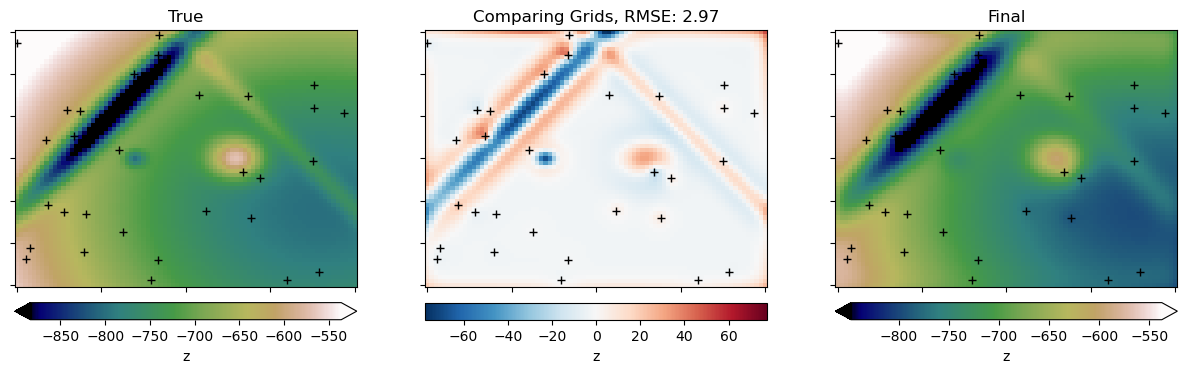

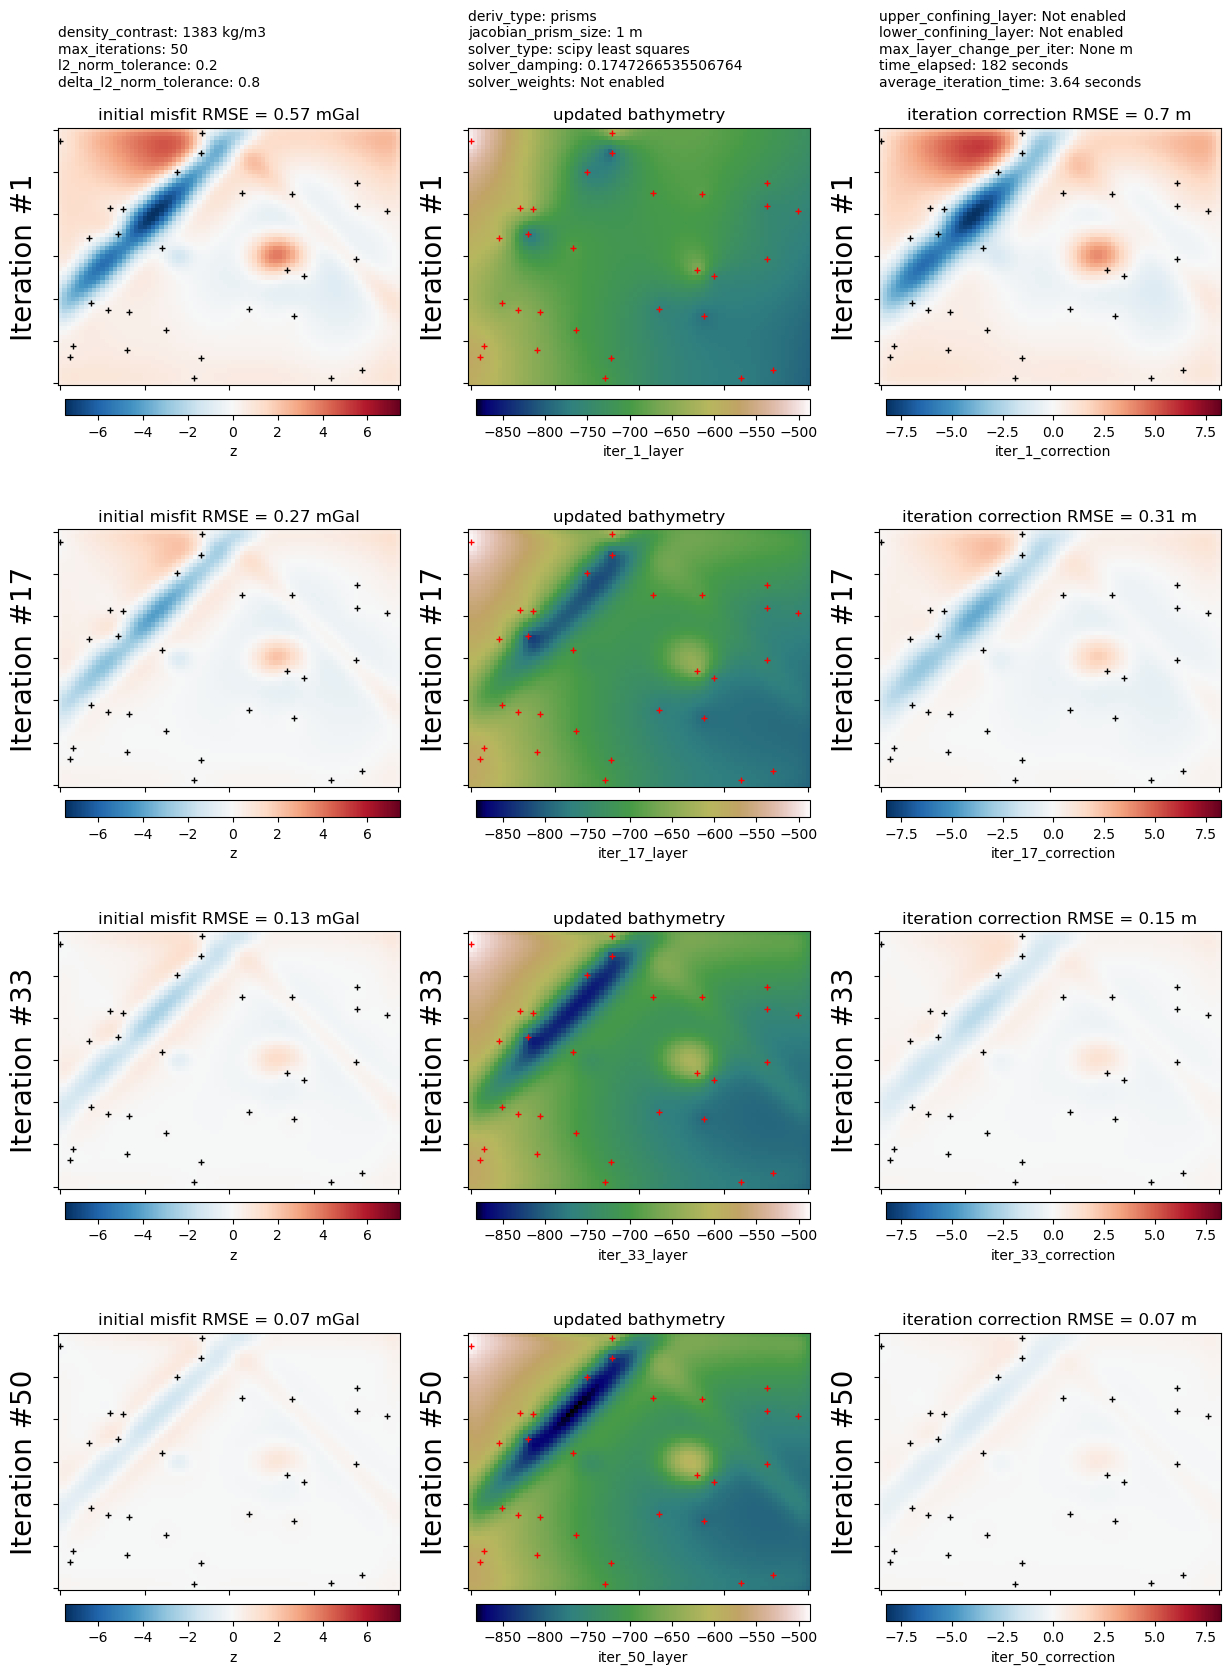

In [22]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **no_noise_kwargs
)

{'deriv_type': 'annulus', 'solver_type': 'scipy least squares', 'scipy_damping': 0.10688314347773964}
returning original grid
returning original grid
RMSE between surfaces at constraints: 4.29 m


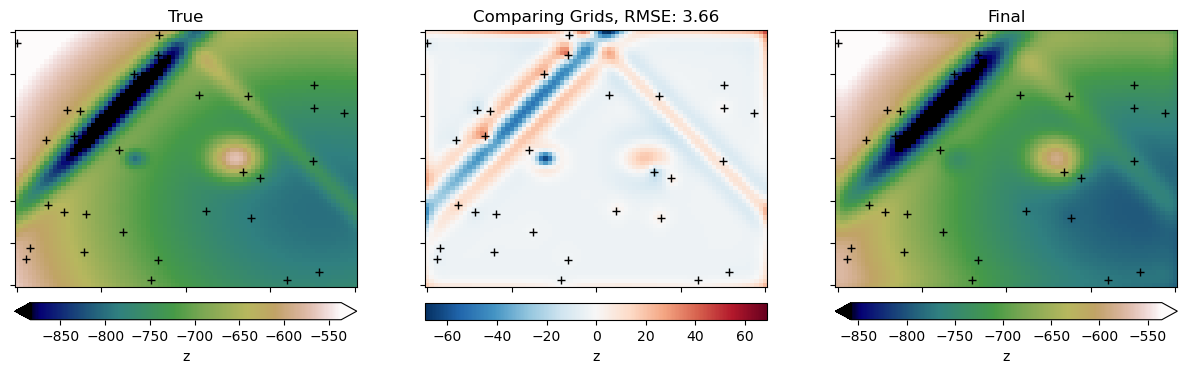

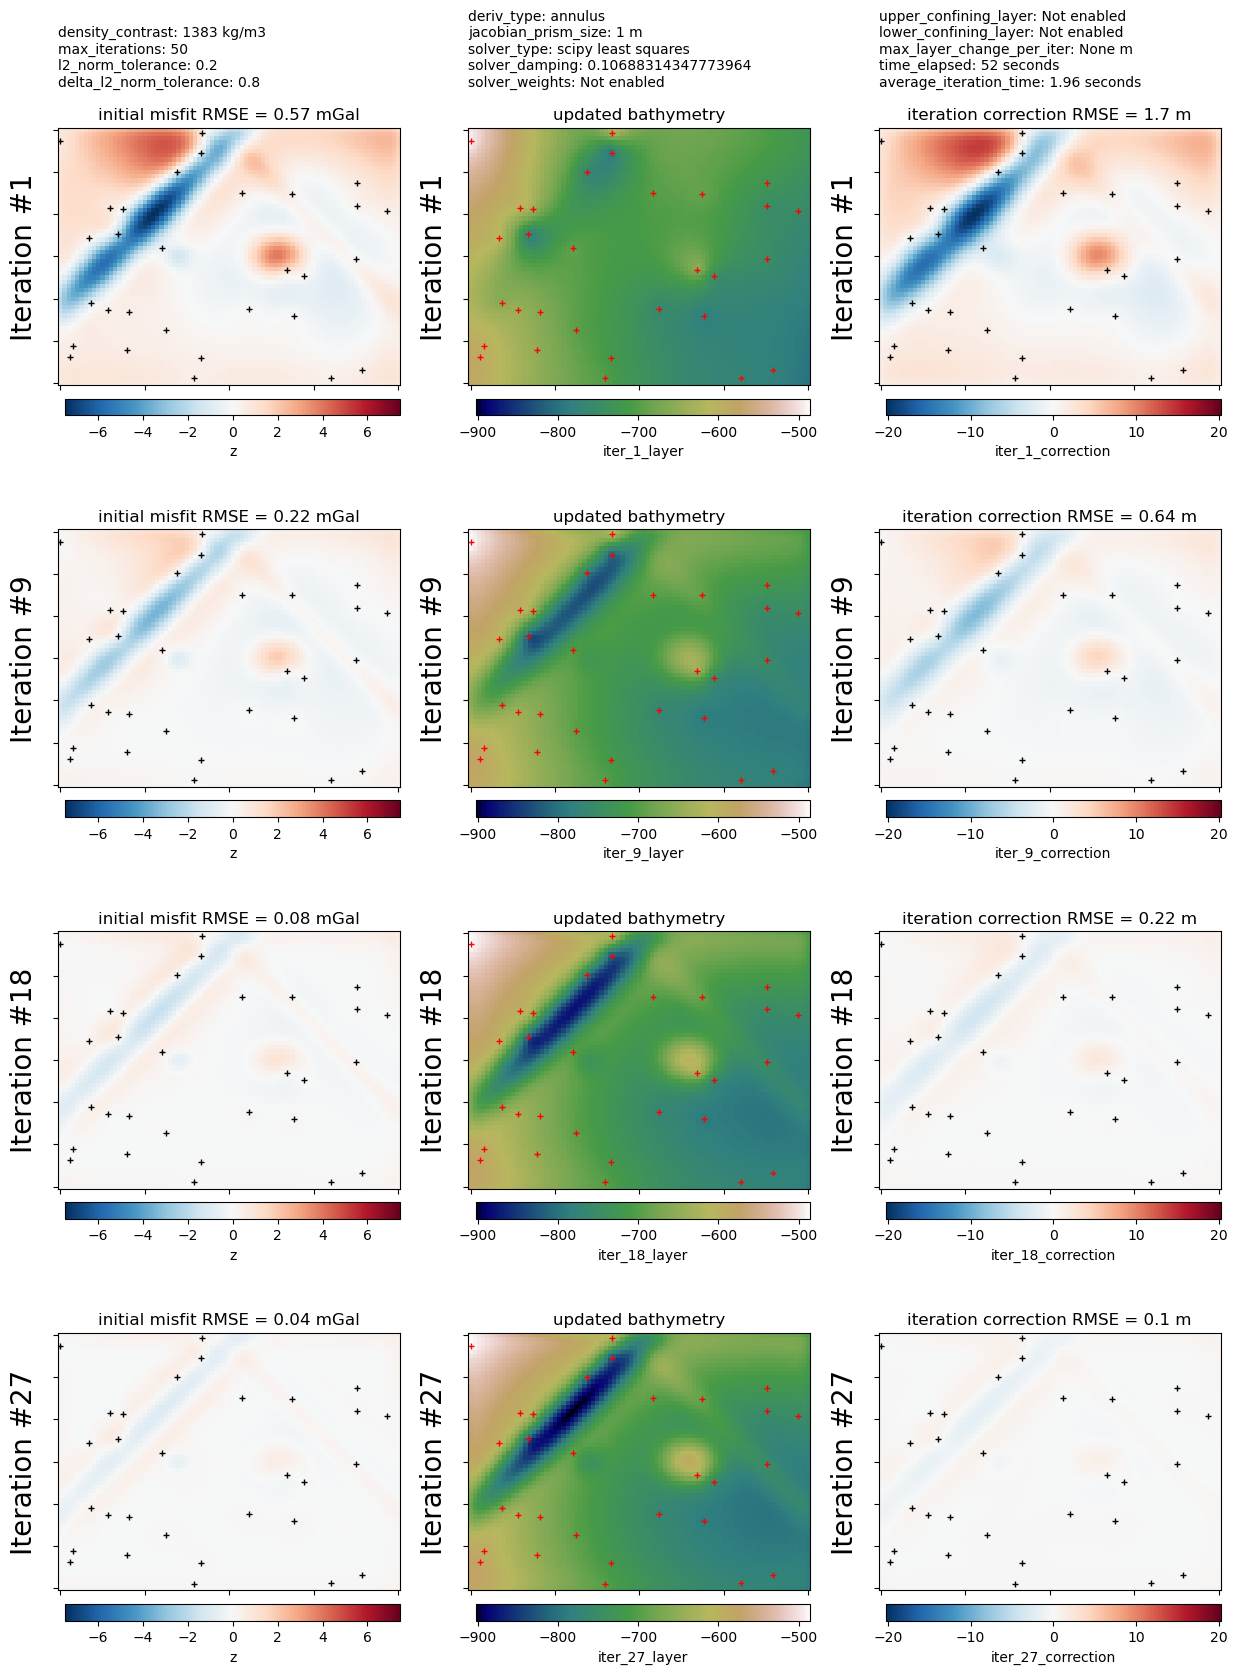

In [23]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **no_noise_kwargs
)

{'deriv_type': 'prisms', 'solver_type': 'verde least squares', 'verde_damping': 8262.597091156715}
returning original grid
returning original grid
RMSE between surfaces at constraints: 10.2 m


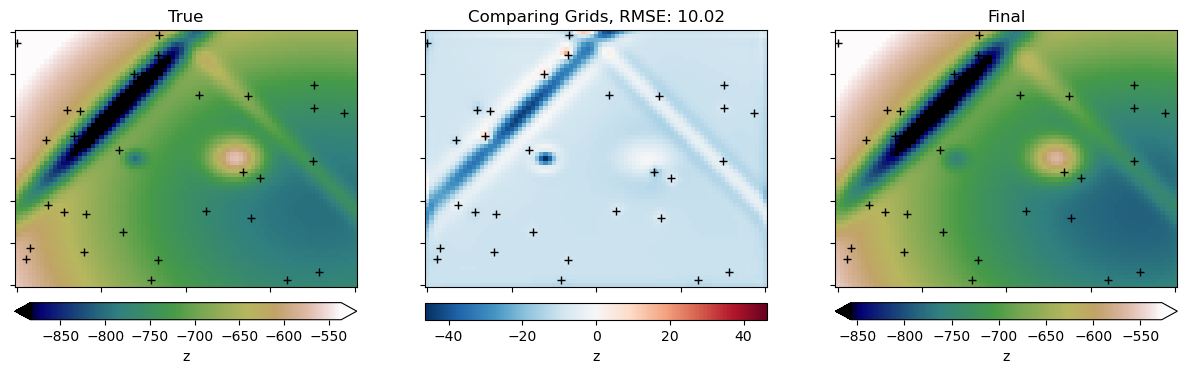

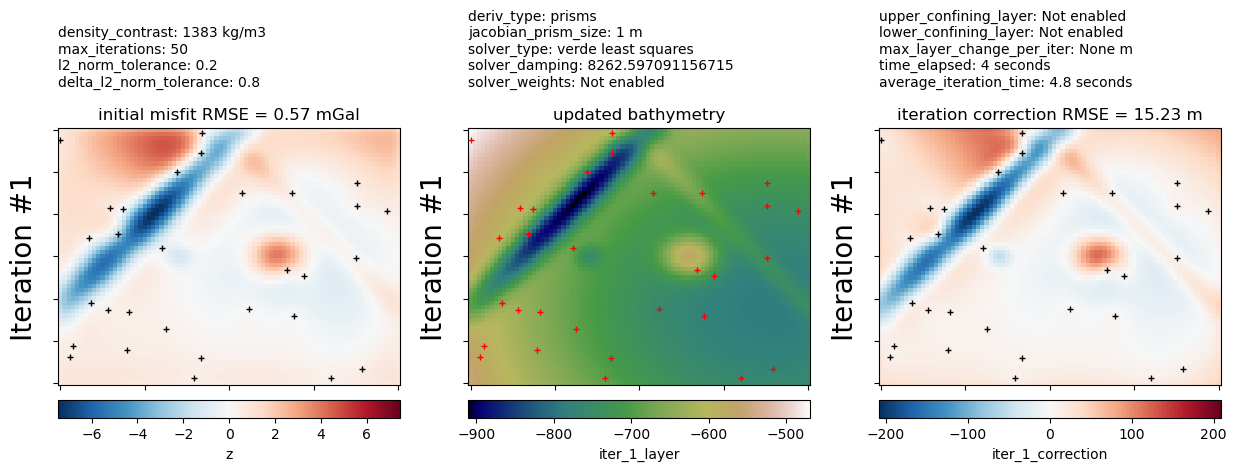

In [24]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **no_noise_kwargs
)

# Repeat with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [19]:
df_misfit_noise = df_misfit.copy()

df_misfit_noise['res'] = synth.contaminate(
    df_misfit_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_misfit_noise

x        y       Gobs       z  layer1_forward  Gobs_corr  \
0         0.0      0.0  10.581479  1000.0        7.079618   3.117193   
1      1000.0      0.0  12.551074  1000.0        8.411450   3.754956   
2      2000.0      0.0  13.172549  1000.0        8.769055   4.018826   
3      3000.0      0.0  13.253567  1000.0        8.776992   4.091908   
4      4000.0      0.0  13.104524  1000.0        8.645779   4.074078   
...       ...      ...        ...     ...             ...        ...   
4936  76000.0  60000.0   3.023554  1000.0        1.019056   1.619829   
4937  77000.0  60000.0   3.088488  1000.0        1.105780   1.598040   
4938  78000.0  60000.0   3.132262  1000.0        1.194986   1.552608   
4939  79000.0  60000.0   3.120086  1000.0        1.282108   1.453309   
4940  80000.0  60000.0   2.984933  1000.0        1.354322   1.245943   

      layer2_forward    misfit  reg       res  
0           2.445618  0.671575    0  0.937134  
1           2.974444  0.780512    0  0.842796  
2           3.201610  0.817216    0  0.965732  
3           3.268290  0.823618    0  1.160245  
4           3.253918  0.820159    0  1.101145  
...              ...       ...  ...       ...  
4936       -0.349516  1.969345    0  1.919871  
4937       -0.382226  1.980266    0  1.882941  
4938       -0.393327  1.945936    0  1.806011  
4939       -0.362025  1.815335    0  1.907096  
4940       -0.253643  1.499586    0  1.434153  

[4941 rows x 10 columns]

In [45]:
# set kwargs for inversion
noise_kwargs = dict(
    input_grav = df_misfit_noise,
    input_grav_column = 'Gobs_corr',
    prism_layer=layer2_prisms,
    max_iterations = 50,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = .8,
)

In [67]:
# set name and storage for the optimization
study_name = "2layer_inversion_noise_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize" 
    # "minimize" 
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = opti.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = opti.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

/tmp/ipykernel_3506921/527452430.py:3: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



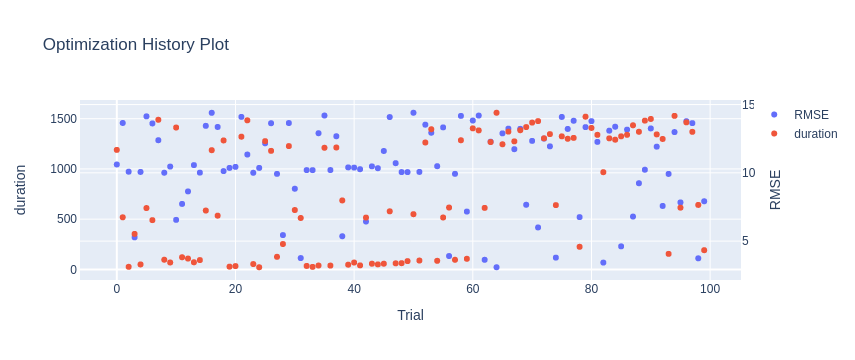

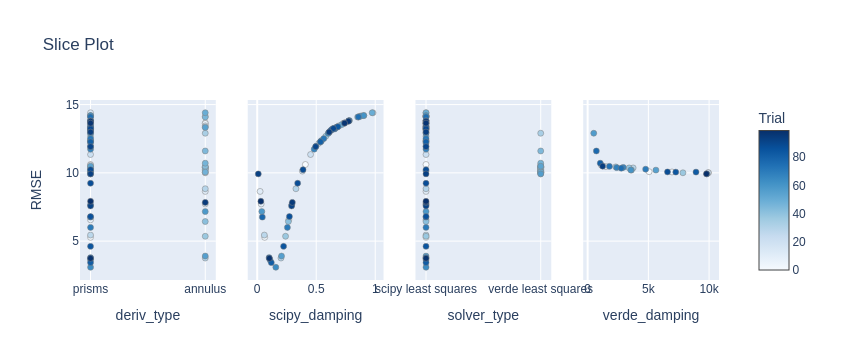

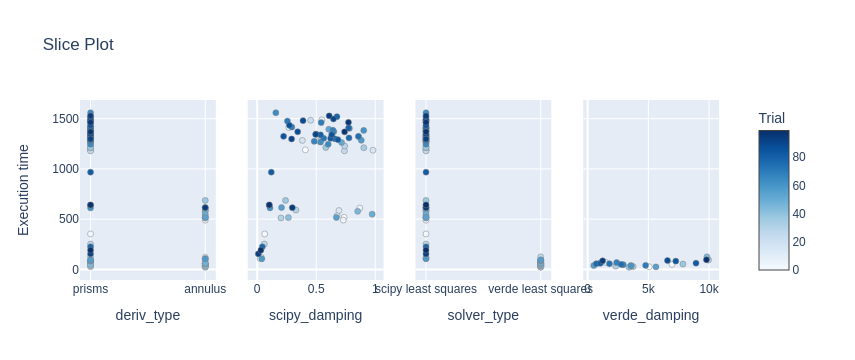

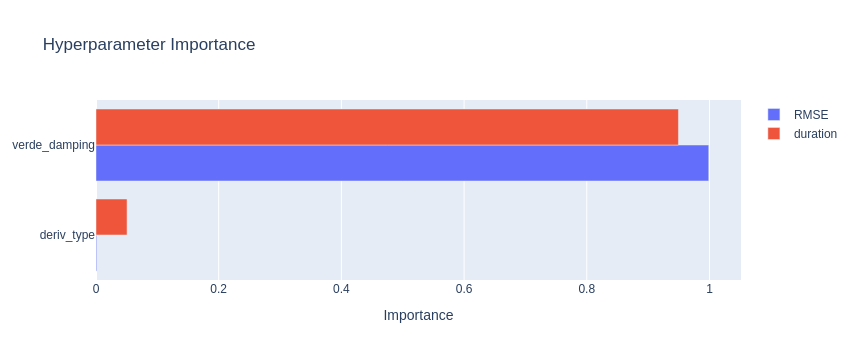

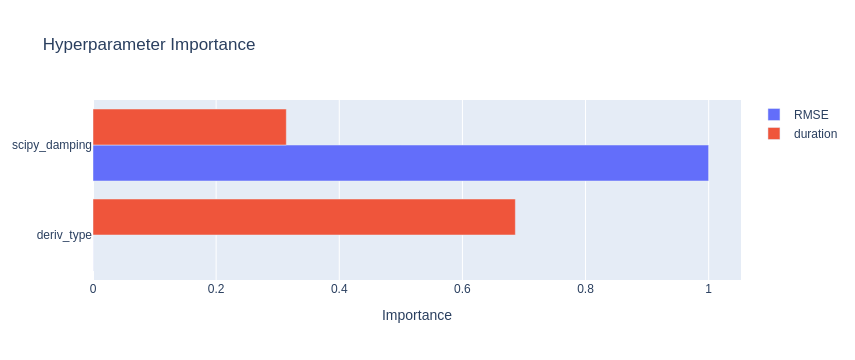

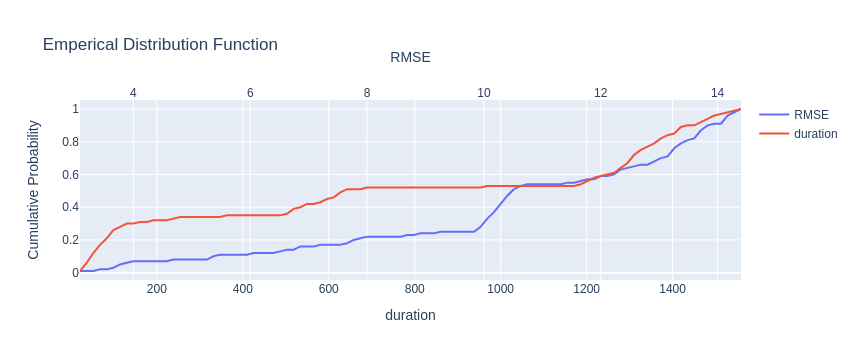

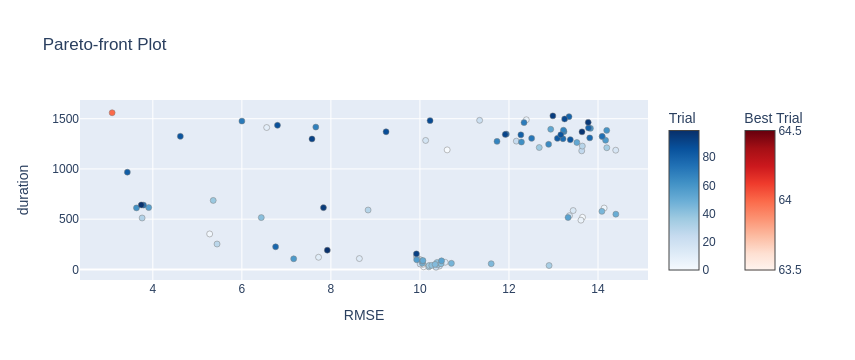

In [69]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    include_duration=True,
)

In [70]:
df_all = study.trials_dataframe()
start = df_all.sort_values(by="datetime_start").iloc[0].datetime_start
stop = df_all.sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

# df_all.sort_values(by="value")[0:20]

Total time for optimizaiton: 26.131871999999998 minutes


In [23]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

best trial w/ solver = verde: index 27
best trial w/ solver = scipy: index 64
best trial w/ deriv = prisms: index 64
best trial w/ deriv = annulus: index 31


number      value             datetime_start          datetime_complete  \
64      64   3.086248 2023-02-28 22:46:32.262311 2023-02-28 23:12:31.419491   
82      82   3.427580 2023-02-28 22:46:31.550068 2023-02-28 23:02:38.910446   
62      62   3.632728 2023-02-28 22:46:30.320489 2023-02-28 22:56:42.310356   
98      98   3.740746 2023-02-28 22:46:29.669868 2023-02-28 22:57:11.255277   
31      31   3.759738 2023-02-28 22:46:34.030715 2023-02-28 22:55:05.593584   
..     ...        ...                        ...                        ...   
58      58  14.170434 2023-02-28 22:46:33.241451 2023-02-28 23:07:58.585815   
61      61  14.196080 2023-02-28 22:46:34.450155 2023-02-28 23:09:37.811189   
35      35  14.197296 2023-02-28 22:46:30.830220 2023-02-28 23:06:41.517591   
16      16  14.398029 2023-02-28 22:46:33.134904 2023-02-28 23:06:19.542269   
50      50  14.400864 2023-02-28 22:46:31.239482 2023-02-28 22:55:40.536961   

                 duration params_deriv_type  params_scipy_damping  \
64 0 days 00:25:59.157180            prisms              0.157662   
82 0 days 00:16:07.360378            prisms              0.119342   
62 0 days 00:10:11.989867            prisms              0.108178   
98 0 days 00:10:41.585409            prisms              0.102951   
31 0 days 00:08:31.562869           annulus              0.201391   
..                    ...               ...                   ...   
58 0 days 00:21:25.344364            prisms              0.881561   
61 0 days 00:23:03.361034            prisms              0.902620   
35 0 days 00:20:10.687371            prisms              0.903175   
16 0 days 00:19:46.407365            prisms              0.980935   
50 0 days 00:09:09.297479           annulus              0.973983   

     params_solver_type  params_verde_damping     state  
64  scipy least squares                   NaN  COMPLETE  
82  scipy least squares                   NaN  COMPLETE  
62  scipy least squares                   NaN  COMPLETE  
98  scipy least squares                   NaN  COMPLETE  
31  scipy least squares                   NaN  COMPLETE  
..                  ...                   ...       ...  
58  scipy least squares                   NaN  COMPLETE  
61  scipy least squares                   NaN  COMPLETE  
35  scipy least squares                   NaN  COMPLETE  
16  scipy least squares                   NaN  COMPLETE  
50  scipy least squares                   NaN  COMPLETE  

[100 rows x 10 columns]

{'deriv_type': 'prisms', 'solver_type': 'scipy least squares', 'scipy_damping': 0.15766151074601498}
returning original grid
returning original grid
RMSE between surfaces at constraints: 4.61 m


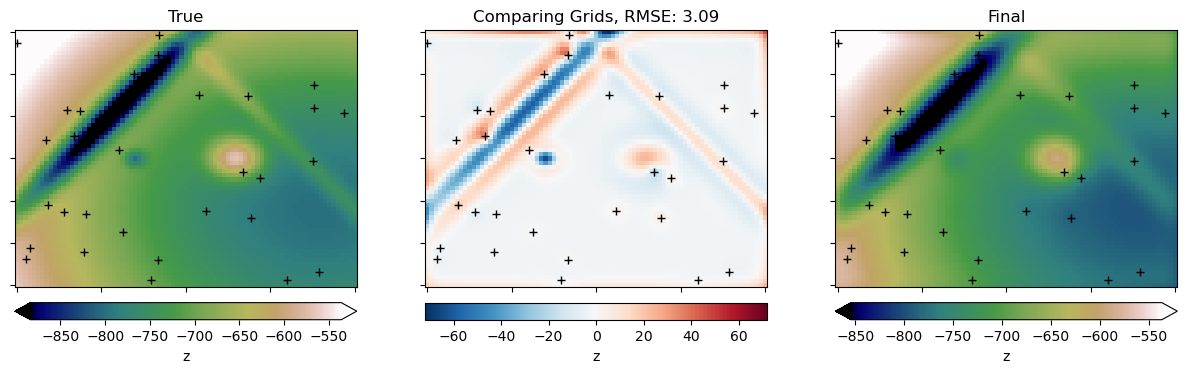

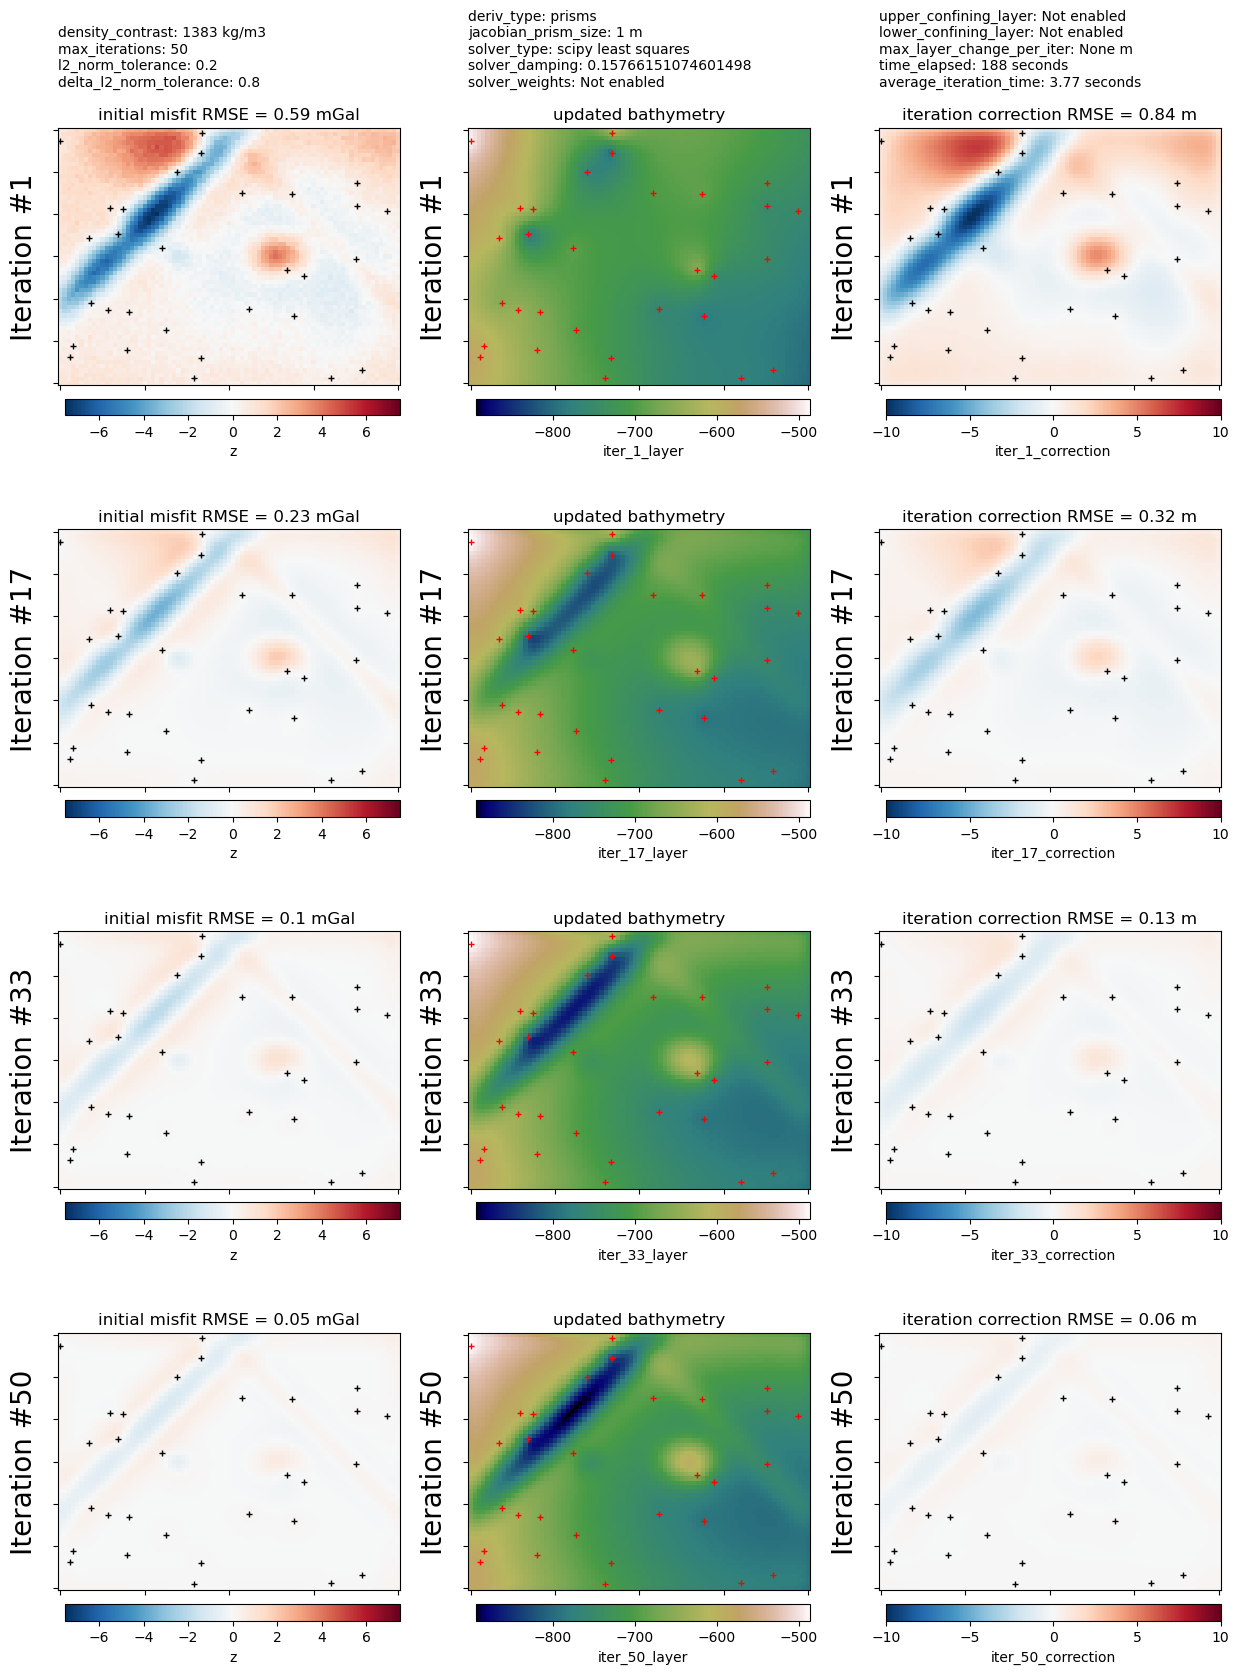

In [24]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

{'deriv_type': 'annulus', 'solver_type': 'scipy least squares', 'scipy_damping': 0.20139138733877526}
returning original grid
returning original grid
RMSE between surfaces at constraints: 3.71 m


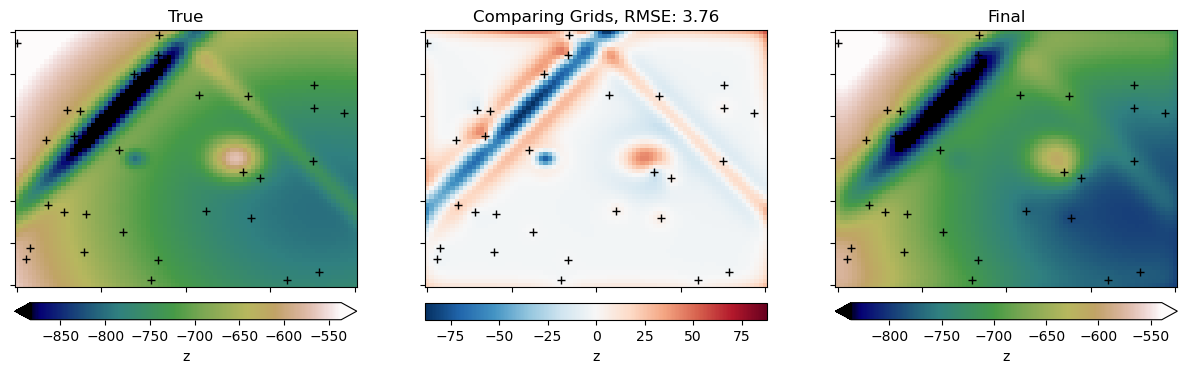

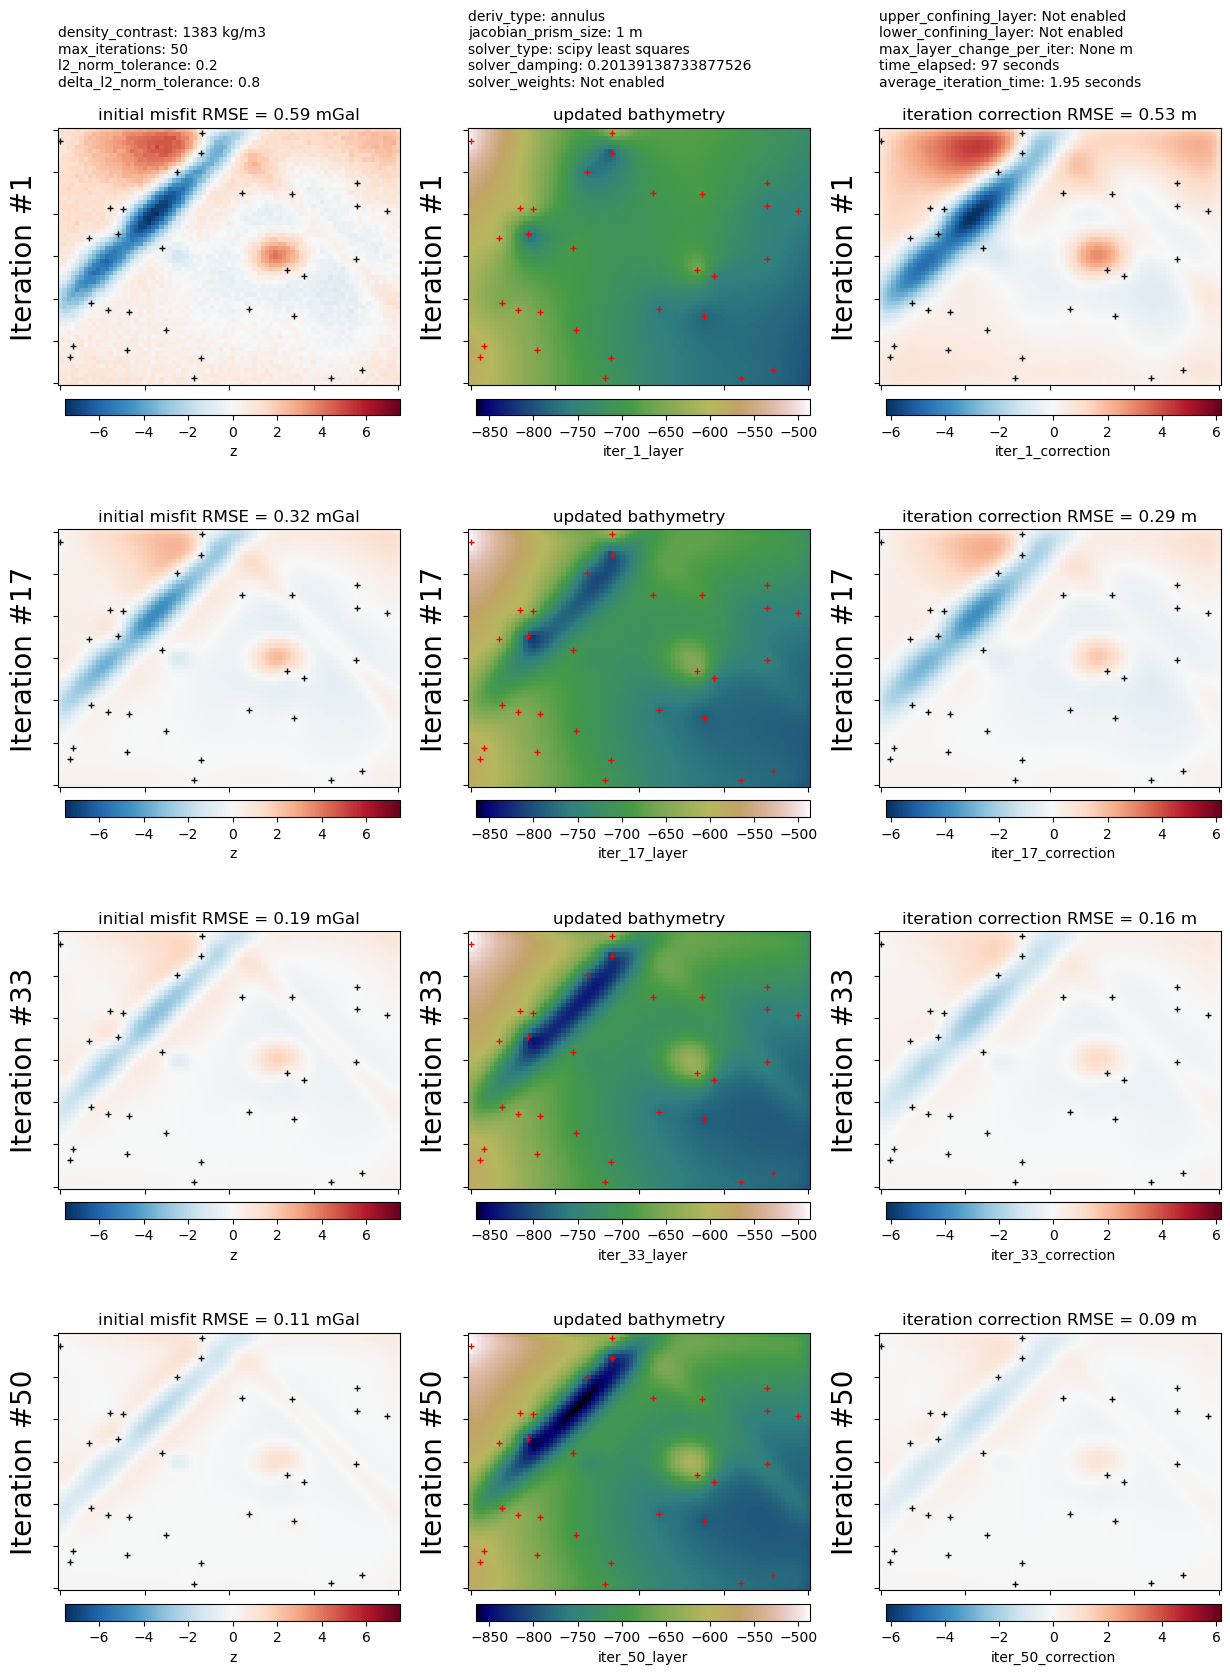

In [25]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

{'deriv_type': 'prisms', 'solver_type': 'verde least squares', 'verde_damping': 9818.941623337723}
returning original grid
returning original grid
RMSE between surfaces at constraints: 9.83 m


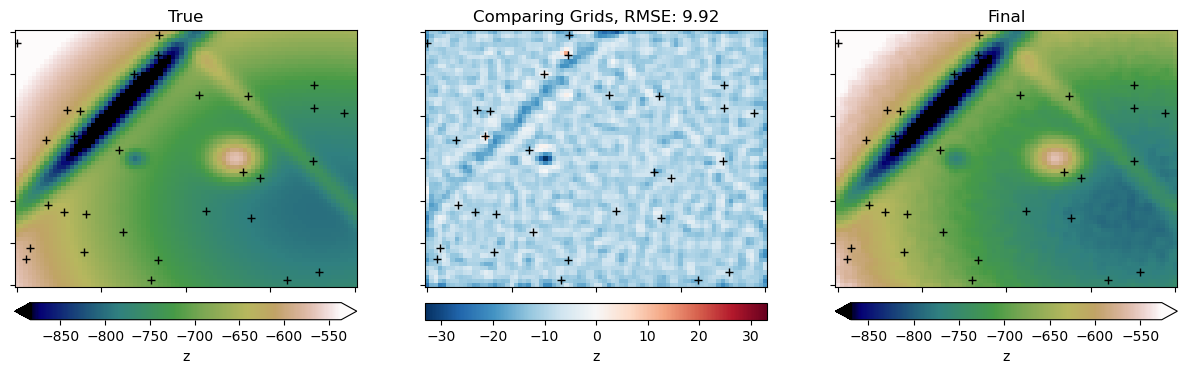

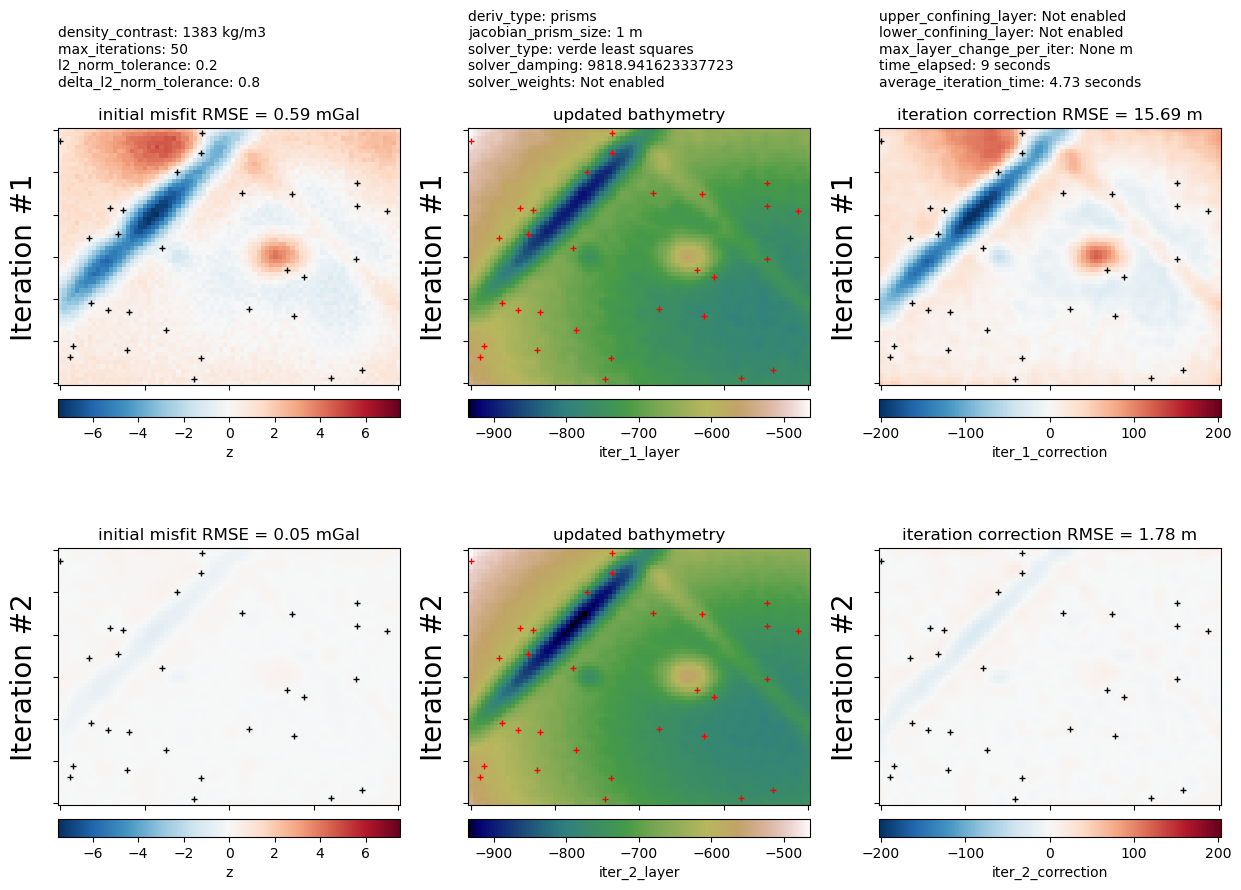

In [26]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

In [ ]:
# ds_noise = prism_results.rename(columns={'easting':'x', 'northing':'y'}).set_index(['y', 'x']).to_xarray()

# ds_noise_inner = ds_noise.sel(
#     x=slice(inversion_region[0], inversion_region[1]),
#     y=slice(inversion_region[2], inversion_region[3])
# )

# cols = [s for s in prism_results.columns.to_list() if "_layer" in s]
# for i, j in enumerate(cols, start=1):
#     dif = true_layer2 - ds_noise_inner[j]
#     RMSE = inv.RMSE(dif)
#     print(f"RMSE iter {i}: {round(RMSE, 2)}m")

# final_layer2_noise = ds_noise_inner[cols[-1]]

In [ ]:
# grids = utils.grd_compare(
#     true_layer2,
#     final_layer2_noise,
#     grid1_name='True layer 2',
#     grid2_name='Final layer 2',
#     region=inversion_region,
#     plot=True,
#     plot_type="pygmt",
#     cmap='batlowW',
#     # cmap="gist_earth",
#     robust=True,
#     points=constraint_points,
#     hist=True,
#     inset=False,
# )

In [28]:
# grids = utils.grd_compare(
#     final_layer2,
#     final_layer2_noise,
#     grid1_name='Final layer 2',
#     grid2_name='Final layer 2 with noise',
#     region=inversion_region,
#     plot=True,
#     plot_type="pygmt",
#     cmap='batlowW',
#     # cmap="gist_earth",
#     robust=True,
#     points=constraint_points,
#     hist=True,
#     inset=False,
# )